In [1]:
# Run this the first time you load this notebook
# Once it finishe running, go to Runtime > Restart Runtime
# Once Runtime restarts, continue running cells in order (including this one)
!pip install -q --upgrade arviz
!pip install -q --upgrade pymc3

In [2]:
import pymc3 as pm
import scipy.stats as stats
import numpy as np
import pylab as plt
from joblib import cpu_count

import warnings
warnings.filterwarnings('ignore')

## ==== Generate Gaussian Data ====

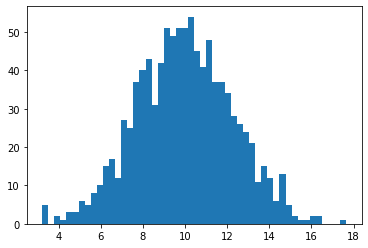

In [36]:
true_mu = 10
true_var = 5
sample_count = 1000
# The multivariate normal function requires mu and variance (not sd)
our_gauss_dist = stats.multivariate_normal(true_mu,true_var)
gauss_samples = our_gauss_dist.rvs(sample_count)

# Calculate sample statistics
sample_mean = gauss_samples.mean()
sample_std = gauss_samples.std()

# Plot data
plt.hist(gauss_samples,bins=50);

## ==== Gaussian Model ====

In [37]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors (variables of interest)

    # Normal prior over mean
    mu = pm.Normal('mu',mu=0, sigma = 20)
    # Half-normal prior of stanard deviation
    sigma = pm.HalfNormal('sigma', sigma = 20)

    # Define Normal likelihood for data
    obs = pm.Normal('obs', mu = mu, sigma = sigma, observed = gauss_samples)

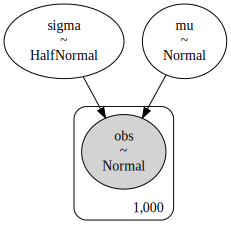

In [38]:
# Plot the graph for the model
pm.model_to_graphviz(model)

In [39]:
# Run inference on the model
with model:
    trace = pm.sample(3000, cores=cpu_count())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 7 seconds.


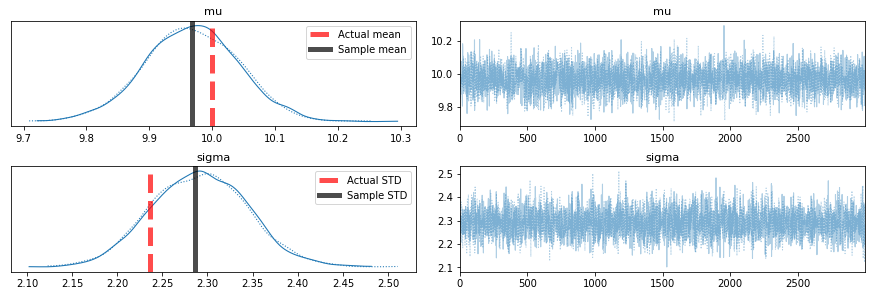

In [40]:
# Plot inferred posterior distributions
ax = pm.traceplot(trace);
ax[0,0].axvline(true_mu, linestyle = '--', c = 'red', lw = 5, alpha = 0.7, label = 'Actual mean')
ax[1,0].axvline(np.sqrt(true_var), linestyle = '--', c = 'red', lw = 5, alpha = 0.7, label = 'Actual STD')
ax[0,0].axvline(sample_mean, linestyle = '-', c = 'black', lw = 5, alpha = 0.7, label = 'Sample mean')
ax[1,0].axvline(sample_std, linestyle = '-', c = 'black', lw = 5, alpha = 0.7, label = 'Sample STD')
ax[0,0].legend();
ax[1,0].legend();

In [41]:
## Generate samples of the obervations from the posterior
ppc_count = 5
with model:
  ppc = pm.sample_posterior_predictive(trace,ppc_count)

Text(0.5, 1.0, 'Actual')

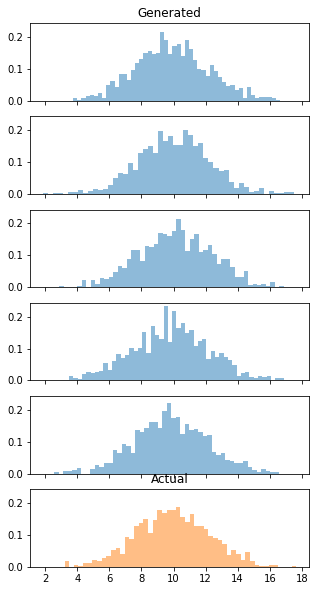

In [42]:
cmap = plt.cm.get_cmap('tab10')
fig, ax = plt.subplots(ppc_count+1,1,sharex=True, sharey=True, figsize = (5,10))
for i in range(ppc_count):
  ax[i].hist(ppc['obs'][i],bins = 50,alpha = 0.5, density=True, color = cmap(0));
ax[-1].hist(gauss_samples,bins = 50,alpha = 0.5, density=True,  color = cmap(1));
ax[0].set_title('Generated')
ax[-1].set_title('Actual')

## Conceptual questions : 
1.   How do we get multiple samples of distributions? I thought we were generating single datapoints?
2.   Why do we want to see multiple distributions?